In [1]:
!pip install --upgrade transformers

     |████████████████████████████████| 499 kB 4.1 MB/s 
     |████████████████████████████████| 3.7 MB 7.3 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.0.11
    Uninstalling tokenizers-0.0.11:
      Successfully uninstalled tokenizers-0.0.11
  Attempting uninstall: transformers
    Found existing installation: transformers 2.4.1
    Uninstalling transformers-2.4.1:
      Successfully uninstalled transformers-2.4.1


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from transformers import (
    BertTokenizer,
    TFBertForSequenceClassification,
    TFBertModel,
    BertConfig,
)
tf.__version__

'2.1.0'

In [4]:
MAX_SEQUENCE_LENGTH = 255
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 32

In [5]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [6]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
data = df['text'].values
targets = df['target'].values

In [10]:
def create_model():
    bert_model = TFBertModel.from_pretrained(PRETRAINED_MODEL_NAME)
    
    input_ids = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
    token_type_ids = layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids')
    attention_mask = layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')
    
    # Use pooled_output(hidden states of [CLS]) as sentence level embedding
    pooled_output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})[1]
    x = layers.Dropout(rate=0.1)(pooled_output)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = keras.models.Model(inputs={'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}, outputs=x)
    return model

In [11]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
model = create_model()

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 255)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 255)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 255)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 255, 768), ( 109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]              

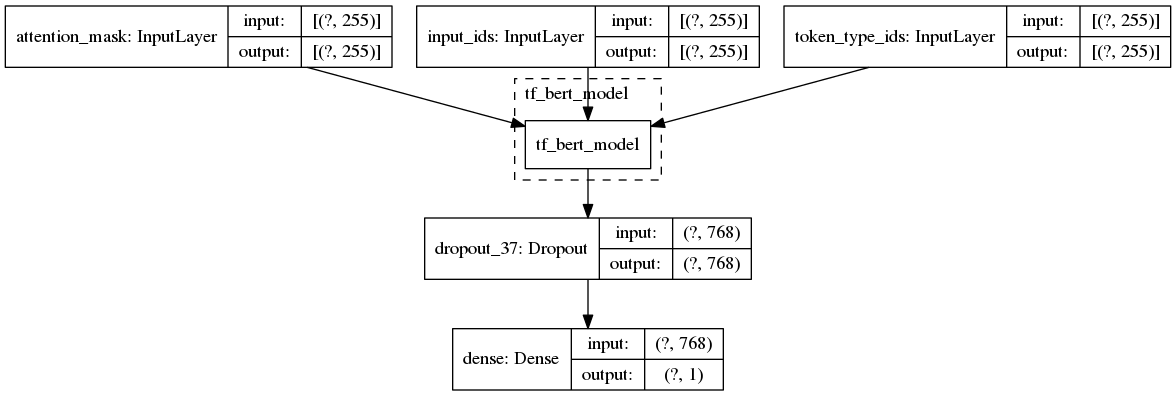

In [13]:
plot_model(model, to_file='model.png', expand_nested=True, show_shapes=True)

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
X_train, X_val, y_train, y_val = train_test_split(data, targets, test_size=0.33, random_state=42, stratify=targets)

In [16]:
X_train = tokenizer.batch_encode_plus(X_train, max_length=MAX_SEQUENCE_LENGTH, pad_to_max_length=True, return_tensors='tf')
X_val = tokenizer.batch_encode_plus(X_val, max_length=MAX_SEQUENCE_LENGTH, pad_to_max_length=True, return_tensors='tf')

In [17]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=BATCH_SIZE
)

Train on 5100 samples, validate on 2513 samples
Epoch 1/3
5100/5100 [==============================] - 197s 39ms/sample - loss: 0.4626 - accuracy: 0.7871 - val_loss: 0.3980 - val_accuracy: 0.8309
Epoch 2/3
5100/5100 [==============================] - 177s 35ms/sample - loss: 0.3088 - accuracy: 0.8757 - val_loss: 0.3882 - val_accuracy: 0.8404
Epoch 3/3
5100/5100 [==============================] - 177s 35ms/sample - loss: 0.1967 - accuracy: 0.9265 - val_loss: 0.4644 - val_accuracy: 0.8166


In [18]:
y_pred = model.predict(x=X_val, batch_size=BATCH_SIZE)

In [19]:
y_pred_bin = (y_pred > 0.5).astype(int).reshape(-1)

In [20]:
print(classification_report(y_val, y_pred_bin))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1433
           1       0.80      0.76      0.78      1080

    accuracy                           0.82      2513
   macro avg       0.81      0.81      0.81      2513
weighted avg       0.82      0.82      0.82      2513



In [21]:
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [22]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [23]:
X_test = df_test['text'].values
X_test = tokenizer.batch_encode_plus(X_test, max_length=MAX_SEQUENCE_LENGTH, pad_to_max_length=True, return_tensors='tf')
y_pred = model.predict(x=X_test, batch_size=BATCH_SIZE)

In [24]:
y_pred_bin = (y_pred > 0.5).astype(int).reshape(-1)
df_test['target'] = y_pred_bin
df_test[['id', 'target']].to_csv('submission.csv', index=False)